In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

In [373]:
N_voltages          = 10000
time_step           = 1e-10
time_steps          = np.arange(N_voltages)*time_step*1e9
U_0                 = 0.1 #0.02
folder_nonlinear    = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_two_step_input/"
relaxation_time     = 30e-9
steps_per_step      = int(np.round(relaxation_time/time_step))
time_between        = [0,1e-9,2e-9,4e-9,8e-9,16e-9,32e-9,64e-9,128e-9,256e-9]
steps_between       = [int(np.round(t/time_step)) for t in time_between]
voltages            = []

for i in range(len(time_between)):
    s                                           = steps_between[i]
    volt                                        = np.zeros(N_voltages)
    volt[:steps_per_step]                       = U_0
    volt[steps_per_step+s:2*steps_per_step+s]   = U_0
    voltages.append(volt)

pot_nonlinear       = {step : pd.concat([pd.DataFrame([np.zeros(9*9)]),
                                         pd.read_csv(f"{folder_nonlinear}mean_state_Nx=9_Ny=9_Nz=1_Ne=8_{step}.csv", names=np.arange(81), header=0)],
                                         ignore_index=True) for step in steps_between}
np_center_idx       = [4+9*i for i in range(9)]
step_function_idx   = [[0,steps_per_step,steps_per_step+s,2*steps_per_step+s] for s in steps_between]

(-10.0, 200.0)

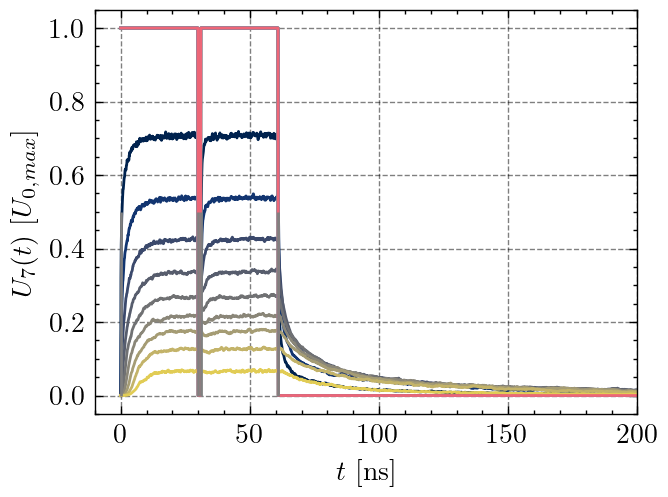

In [388]:
norm    = Normalize(vmin=0, vmax=9)
s_betw  = 10
y_min   = 0
y_max   = 0.5
i_betw  = np.where(np.array(steps_between)==s_betw)[0][0]
x       = voltages[i_betw].copy()/U_0

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

for i_np in range(9):
    y   = pot_nonlinear[s_betw].iloc[:,np_center_idx[i_np]].values/U_0
    ax.plot(time_steps, y, color=cm(norm(i_np)))
    ax.plot(time_steps, x)
    
ax.vlines(x=time_steps[step_function_idx[i_betw]], ymin=y_min, ymax=y_max, colors='grey')
ax.set_ylabel("$U_7(t)$ [$U_{0,max}$]")
ax.set_xlabel("$t$ [ns]")
# ax.set_yscale("log")
# ax.set_ylim(y_min, y_max)
ax.set_xlim(-10,200)

In [386]:
def saturation_cuve(t, tau, a0):
    return a0*(1 - np.exp(-(t) / tau))

def stretched_saturation_curve(t, tau, a0, beta):
    return a0*(1 - np.exp(-((t/tau)**beta)))

func    = stretched_saturation_curve
bounds  = (0,np.inf)
p0      = [3,1,1]

i_NP    = 0
s_betw  = 10
i_betw  = np.where(np.array(steps_between)==s_betw)[0][0]
idx_val = step_function_idx[i_betw]
y       = pot_nonlinear[s_betw].iloc[:,np_center_idx[i_np]].values.copy()
xf1     = time_steps[idx_val[0]:idx_val[1]]
yf1     = y[idx_val[0]:idx_val[1]]
xf2     = time_steps[idx_val[2]:idx_val[3]]
yf2     = y[idx_val[2]:idx_val[3]]
yf2     = yf2 - yf2[0]
p1, _   = curve_fit(func, xf1, yf1, bounds=bounds, p0=p0)
p2, _   = curve_fit(func, xf1, yf2, bounds=bounds, p0=p0)

print(p1)
print(p2)

[9.05328845e+00 6.58560593e-03 2.47572999e+00]
[8.67664865e+03 2.83040559e-02 7.85466081e-01]


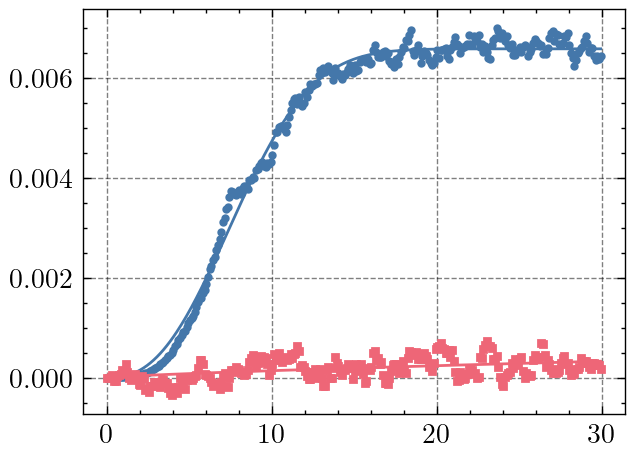

In [389]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p   = ax.plot(xf1, yf1, 'o', ms=2)
ax.plot(xf1, func(xf1,*p1), color=p[0].get_color())
p   = ax.plot(xf1, yf2, 's', ms=2)
ax.plot(xf1, func(xf1,*p2), color=p[0].get_color())

# plt.plot(xf1, yf1)
# plt.plot(xf1, func(xf1,*p1))
# plt.plot(xf2, yf2)
# plt.plot(xf2, func(xf1,*p2))
# plt.plot(time_steps, y, alpha=0.5)
# plt.xlim(0,100)